# MS017 Preprocess
01/10/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/afink_lfp_pipeline/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [6]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
anat_dir = f'{base_dir}anat_recons/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}behavior_analysis/behavior_preprocessed/'

subj_id = 'MS017'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [9]:
mne_data

<RawEDF | MS017_SWB.edf, 276 x 2282048 (2228.6 s), ~4.69 GB, data loaded>

In [10]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'LalpS1',
 'LalpS2',
 'LalpS3',
 'LalpS4',
 'LalpS5',
 'LalpS6',
 'LalpS7',
 'LalpS8',
 'LalpS9',
 'LalpS10',
 'LalpS11',
 'LalpS12',
 'LalpS13',
 'LalpS14',
 'LmlBr1',
 'LmlBr2',
 'LmlBr3',
 'LmlBr4',
 'LmlBr5',
 'LmlBr6',
 'LpCWr1',
 'LpCWr2',
 'LpCWr3',
 'LpCWr4',
 'LpCWr5',
 'LpCWr6',
 'LpCWr7',
 'LpCWr8',
 'LpCWr9',
 'LpCWr10',
 'LpCWr11',
 'LpCWr12',
 'LllT1',
 'LllT2',
 'LllT3',
 'LllT4',
 'LllT5',
 'LllT6',
 'LllT7',
 'LllT8',
 'Lpl

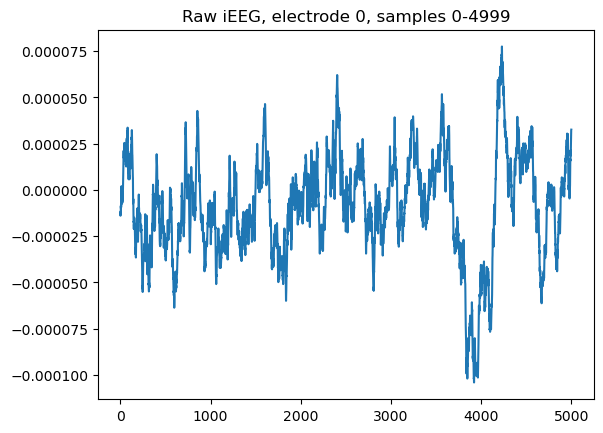

In [11]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [12]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   16.2s finished


<RawEDF | MS017_SWB.edf, 276 x 1114281 (2228.6 s), ~2.29 GB, data loaded>

### Photodiode
- examine photodiode 
- save out before resampling/notch filtering *unless nlx - then you have to resample first 

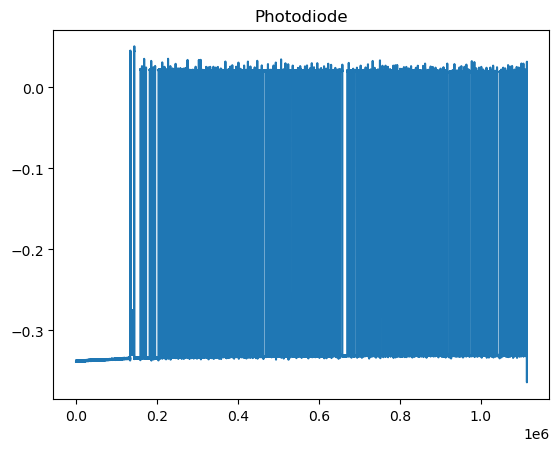

In [13]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Research")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [15]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='Research', overwrite=True)

In [16]:
mne_data.drop_channels(['Research'])

<RawEDF | MS017_SWB.edf, 275 x 1114281 (2228.6 s), ~2.28 GB, data loaded>

### Notch filter line noise

In [17]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    6.8s finished


<RawEDF | MS017_SWB.edf, 275 x 1114281 (2228.6 s), ~2.28 GB, data loaded>

### Anatomical Localization

In [18]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS017_SWB.edf, 275 x 1114281 (2228.6 s), ~2.28 GB, data loaded>

In [19]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,umOlF,A11m_L,-5.954451,58.308871,-5.446998,-5.251752,52.377382,-19.502634,Gray,Left GRe gyrus rectus,Area Fo1,L Rectal Gyrus,L OrG,Left frontal orbital 2 A,WM,NaN
1,uLAgIT,mAmyg_L,-17.951753,11.146713,-15.841007,-18.630204,-2.284212,-22.591126,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala inferior,NaN,NaN
2,LaCaS1,A32sg_L,-5.954451,37.525547,2.948164,-5.375178,31.113916,-6.133334,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,WM,NaN
3,LaCaS10,A9l_L,-10.353462,45.119454,48.921668,-9.051641,49.423312,46.098305,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
4,LaCaS11,Unknown,-10.753372,46.318492,52.119825,-9.423595,51.602239,49.768326,Unknown,Unknown,Unknown,L Superior Medial Gyrus,Unknown,Left superior frontal gyrus 2 C,OOB,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,LTPlT4,A21r_L,-36.347618,23.536772,-25.835248,-38.966744,9.549138,-35.666432,White,Left TMP temporal pole,Unknown,L Inferior Temporal Gyrus,L MTG,Left superior middle temporal pole D,WM,NaN
106,LTPlT5,A21r_L,-41.146539,23.137092,-25.035708,-44.119363,9.465391,-34.533635,Gray,Left TMP temporal pole,Unknown,L Inferior Temporal Gyrus,L MTG,Left superior middle temporal pole D,Left inferior middle temporal pole C,NaN
107,LTPlT6,A21r_L,-46.345370,22.737413,-23.836399,-49.685882,9.485142,-32.884898,Gray,Left TMP temporal pole,Unknown,L Medial Temporal Pole,L MTG,Left superior middle temporal pole D,NaN,NaN
108,LTPlT7,A21r_L,-50.744381,22.737413,-22.637091,-54.349179,9.952847,-31.341105,Gray,Left TMP temporal pole,Unknown,L Medial Temporal Pole,L MTG,Left superior middle temporal pole D,NaN,NaN


In [20]:
list(elec_locs.label)

['umOlF',
 'uLAgIT',
 'LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LalpS1',
 'LalpS10',
 'LalpS11',
 'LalpS12',
 'LalpS13',
 'LalpS14',
 'LalpS2',
 'LalpS3',
 'LalpS4',
 'LalpS5',
 'LalpS6',
 'LalpS7',
 'LalpS8',
 'LalpS9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LllT1',
 'LllT2',
 'LllT3',
 'LllT4',
 'LllT5',
 'LllT6',
 'LllT7',
 'LllT8',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmlBr1',
 'LmlBr2',
 'LmlBr3',
 'LmlBr4',
 'LmlBr5',
 'LmlBr6',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LpCWr1',
 'LpCWr10',
 'LpCWr11',
 'LpCWr12',
 'LpCWr2',
 'LpCWr3',
 'LpCWr4',
 'LpCWr5',
 'LpCWr6',
 'LpCWr7',
 'LpCW

In [21]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c109', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c154', 'c155', 'c156', 'c157', 'c158', 'c159', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237',

In [22]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [23]:
unmatched_seeg #make sure there are no unmatched names


[]

In [24]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [25]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'lmcms1': 'lmcms1',
 'lmcms2': 'lmcms2',
 'lmcms3': 'lmcms3',
 'lmcms4': 'lmcms4',
 'lmcms5': 'lmcms5',
 'lmcms6': 'lmcms6',
 'lmcms7': 'lmcms7',
 'lmcms8': 'lmcms8',
 'lmcms9': 'lmcms9',
 'lmcms10': 'lmcms10',
 'laglt1': 'laglt1',
 'laglt2': 'laglt2',
 'laglt3': 'laglt3',
 'laglt4': 'laglt4',
 'laglt5': 'laglt5',
 'laglt6': 'laglt6',
 'laglt7': 'laglt7',
 'laglt8': 'laglt8',
 'laglt9': 'laglt9',
 'lhplt1': 'lhplt1',
 'lhplt2': 'lhplt2',
 'lhplt3': 'lhplt3',
 'lhplt4': 'lhplt4',
 'lhplt5': 'lhplt5',
 'lhplt6': 'lhplt6',
 'lhplt7': 'lhplt7',
 'lhp

In [26]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

In [26]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 108 left sEEG and 0 right sEEG electrodes
We have a total of 108 sEEG electrodes


In [27]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS017_SWB.edf, 275 x 1114281 (2228.6 s), ~2.28 GB, data loaded>

In [28]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS017_SWB.edf, 108 x 1114281 (2228.6 s), ~918.2 MB, data loaded>

In [29]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS017_SWB.edf, 108 x 1114281 (2228.6 s), ~918.3 MB, data loaded>

## Signal Cleaning 
Methods:
- Remove all channels that are obviously noise
- Be LIBERAL with bad labeling - these channels are NOT removed from the dataset, they are just NOT USED to rereference other channels. 
- This process is iterative depending on how TFRs look. 

In [30]:
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 

['lalps13',
 'lhplt2',
 'lhplt3',
 'lmcms10',
 'lmcms2',
 'lmolf9',
 'lpcwr7',
 'lplsp10',
 'lplsp2']

In [31]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [32]:
probe_names

array(['lacas', 'laglt', 'lalps', 'lhplt', 'lllt', 'lmcms', 'lmlbr',
       'lmolf', 'lpcwr', 'lplsp', 'ltplt', 'ulagit', 'umolf'], dtype='<U6')

In [33]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [34]:
probe_ch_counts

{'lacas': 12,
 'laglt': 9,
 'lalps': 14,
 'lhplt': 10,
 'lllt': 8,
 'lmcms': 10,
 'lmlbr': 6,
 'lmolf': 9,
 'lpcwr': 12,
 'lplsp': 10,
 'ltplt': 8,
 'ulagit': 1,
 'umolf': 1}

<IPython.core.display.Javascript object>


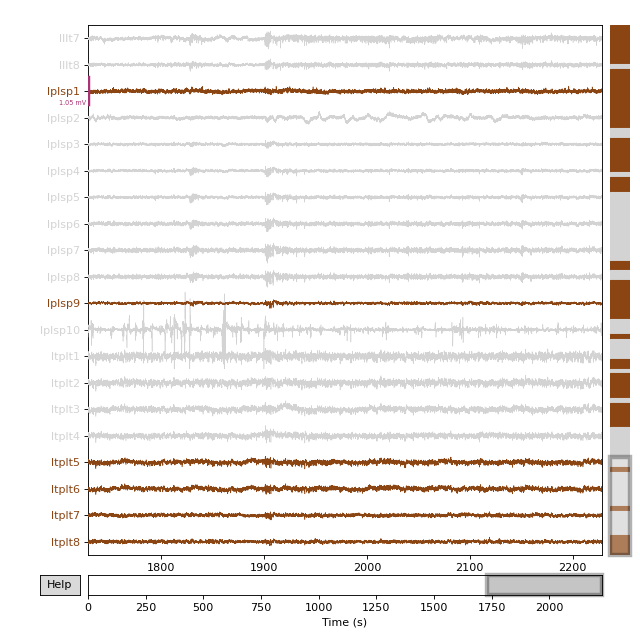

<IPython.core.display.Javascript object>


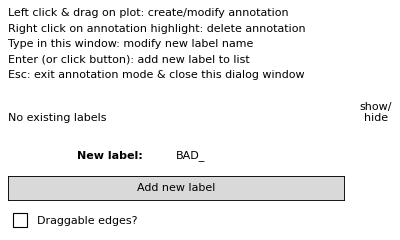

In [35]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=20, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [36]:
mne_data.info['bads']

['lmolf9',
 'lmcms1',
 'lmcms2',
 'lmcms10',
 'laglt6',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'laglt5',
 'laglt7',
 'laglt8',
 'laglt9',
 'laglt4',
 'lhplt4',
 'lhplt5',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lalps1',
 'lalps2',
 'lalps13',
 'lalps11',
 'lalps12',
 'lmlbr1',
 'lmlbr3',
 'lmlbr2',
 'lmlbr4',
 'lpcwr7',
 'lpcwr1',
 'lllt1',
 'lplsp2',
 'lllt8',
 'lllt7',
 'lllt6',
 'lllt5',
 'lllt4',
 'lllt3',
 'lllt2',
 'lplsp3',
 'lplsp4',
 'lplsp5',
 'lplsp10',
 'ltplt1',
 'ltplt2',
 'lplsp6',
 'lplsp7',
 'lplsp8',
 'ltplt3',
 'ltplt4']

In [37]:
#add manually for situations where raw data needs to be updated but manual bad channel inspection does not change 

mne_data.info['bads'] = ['lmolf9', 'lmcms1', 'lmcms2', 'lmcms10', 'laglt6','lhplt1', 'lhplt2', 
                         'lhplt3', 'laglt5', 'laglt7', 'laglt8', 'laglt9', 'laglt4', 'lhplt4',
                         'lhplt5', 'lhplt6','lhplt7', 'lhplt8', 'lalps1', 'lalps2', 'lalps13', 
                         'lalps11', 'lalps12','lmlbr1', 'lmlbr3', 'lmlbr2', 'lmlbr4', 'lpcwr7',
                         'lpcwr1', 'lllt1', 'lplsp2', 'lllt8', 'lllt7', 'lllt6', 'lllt5',
                         'lllt4', 'lllt3', 'lllt2','lplsp3', 'lplsp4', 'lplsp5', 'lplsp10',
                         'ltplt1', 'ltplt2', 'lplsp6', 'lplsp7', 'lplsp8', 'ltplt3','ltplt4']

In [38]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 49 items (lmolf9, lmcms1, lmcms2, lmcms10, laglt6, lhplt1, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 108 sEEG
 custom_ref_applied: False
 dig: 108 items (108 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 15:28:29 UTC
 nchan: 108
 projs: []
 sfreq: 500.0 Hz
>

# Re-referencing 
- wm reref
- bipolar reref

In [39]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### WM Re-ref

In [40]:
# Re-reference neural data
mne_data_wm_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='wm', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [41]:
mne_data_wm_reref

<RawEDF | MS017_SWB.edf, 70 x 1114281 (2228.6 s), ~595.2 MB, data loaded>

In [42]:
mne_data_wm_reref.ch_names

['lacas10-lmcms6',
 'lacas2-lmolf1',
 'lacas4-lacas7',
 'lacas5-lacas7',
 'lacas6-lacas9',
 'lacas8-lacas9',
 'laglt1-laglt3',
 'laglt2-laglt3',
 'laglt4-laglt3',
 'laglt5-laglt3',
 'laglt6-laglt3',
 'laglt7-laglt3',
 'laglt8-laglt3',
 'laglt9-laglt3',
 'lalps1-laglt3',
 'lalps10-lalps9',
 'lalps11-lmcms6',
 'lalps12-lmcms6',
 'lalps13-lmcms6',
 'lalps2-lalps4',
 'lalps3-lalps4',
 'lhplt1-lpcwr3',
 'lhplt2-laglt3',
 'lhplt3-laglt3',
 'lhplt5-laglt3',
 'lhplt6-laglt3',
 'lhplt7-laglt3',
 'lhplt8-laglt3',
 'lhplt9-laglt3',
 'lllt1-lpcwr5',
 'lllt2-lpcwr5',
 'lllt3-lpcwr5',
 'lllt4-lpcwr5',
 'lllt5-lpcwr5',
 'lllt6-lpcwr5',
 'lmcms1-lmcms6',
 'lmcms2-lmcms6',
 'lmcms3-lmcms6',
 'lmcms7-lmcms6',
 'lmlbr1-lalps4',
 'lmlbr2-lalps4',
 'lmlbr3-lalps4',
 'lmlbr4-lalps4',
 'lmolf2-lmolf1',
 'lmolf4-lmolf1',
 'lmolf6-lmolf1',
 'lmolf7-lmolf1',
 'lmolf8-lmolf1',
 'lpcwr1-lpcwr3',
 'lpcwr10-lpcwr4',
 'lpcwr11-lpcwr4',
 'lpcwr7-lpcwr4',
 'lpcwr8-lpcwr4',
 'lpcwr9-lpcwr4',
 'lplsp1-lpcwr4',
 'lplsp2-

In [43]:
mne_data_wm_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)

### Bipolar Re-ref

In [44]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [45]:
mne_data_bp_reref

<RawEDF | MS017_SWB.edf, 29 x 1114281 (2228.6 s), ~246.6 MB, data loaded>

In [46]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'lalps3-lalps4',
 'lalps9-lalps10',
 'lmcms3-lmcms4',
 'lmcms6-lmcms7',
 'lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lpcwr6-lpcwr8',
 'lpcwr8-lpcwr9',
 'lpcwr9-lpcwr10',
 'lpcwr10-lpcwr11',
 'lplsp1-lplsp9',
 'ltplt5-ltplt6',
 'ltplt6-ltplt7']

In [47]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

## Save mne_data

In [48]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [49]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref, mne_data_wm_reref

### Photodiode Alignment

In [50]:
#load behavior data
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [51]:
### Photodiode alignment

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.7)

10 blocks
..........

found matches for 120 of 159 pulses


In [53]:
print(slope, offset)

0.9999876583536949 288.91113934998396


## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [54]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [55]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [56]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [57]:
### MAKE SURE CORRECT REREF FILE IS BEING USED!
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
#     ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.6s finished


In [59]:
epochs_all_evs 

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~120.4 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~280.6 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [60]:
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,32.0,mix,118.400476,118.411163,122.335075,124.351936,3.923912,0.0,-1.50,...,2.49,0.99,0.00,0.00,2.49,0.99,-1.50,0.00,1.245,0.00
1,2,11.0,mix,129.243242,129.252721,131.680515,131.687489,2.427793,0.0,-0.50,...,0.50,0.50,0.00,0.00,0.50,0.50,-0.50,-0.50,0.000,0.00
2,3,58.0,gain,138.569014,138.569721,142.691407,142.699045,4.121686,0.2,0.00,...,-0.52,-0.52,-0.52,-0.52,0.00,0.00,0.72,0.72,0.000,0.00
3,4,107.0,loss,156.066675,156.074704,160.448116,160.455069,4.373412,-0.2,-0.63,...,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.00,0.00,0.000,0.00
4,5,118.0,loss,167.732757,167.733475,171.742701,171.750382,4.009226,-0.3,-1.08,...,-0.30,-0.30,-0.30,-0.30,0.00,0.00,0.00,0.00,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,116.0,loss,1880.174175,1880.181643,1883.601460,1883.608344,3.419817,-0.3,-0.84,...,0.54,0.54,0.00,0.00,0.54,0.54,-0.84,-0.84,0.000,0.00
146,147,29.0,mix,1890.856264,1890.857010,1893.529529,1893.536447,2.672519,0.0,-1.50,...,-0.45,-0.45,-0.45,-0.45,0.00,0.00,0.45,0.45,0.000,0.00
147,148,62.0,gain,1905.140124,1905.147126,1906.989078,1906.996028,1.841952,0.3,0.00,...,0.30,0.30,0.00,0.00,0.30,0.30,0.00,0.00,0.000,0.00
148,149,66.0,gain,1914.440992,1914.444753,1916.783871,1918.799001,2.339119,0.3,0.00,...,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.84,0.30,0.000,-0.42


In [61]:
behav_params = ['SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
                'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
                'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
                'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE','nRPE']

In [62]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [63]:
epochs_all_evs[event].metadata

,lacas10-lmcms6,lacas2-lmolf1,lacas4-lacas7,lacas5-lacas7,lacas6-lacas9,lacas8-lacas9,laglt1-laglt3,laglt2-laglt3,laglt4-laglt3,laglt5-laglt3,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.49,0.99,0.00,0.00,2.49,0.99,-1.50,0.00,1.245,0.00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.50,0.50,0.00,0.00,0.50,0.50,-0.50,-0.50,0.000,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.52,-0.52,-0.52,-0.52,0.00,0.00,0.72,0.72,0.000,0.00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.00,0.00,0.000,0.00
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.30,-0.30,-0.30,-0.30,0.00,0.00,0.00,0.00,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.54,0.54,0.00,0.00,0.54,0.54,-0.84,-0.84,0.000,0.00
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.45,-0.45,-0.45,-0.45,0.00,0.00,0.45,0.45,0.000,0.00
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.30,0.30,0.00,0.00,0.30,0.30,0.00,0.00,0.000,0.00
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.84,0.30,0.000,-0.42


### Save raw epoched data 

In [64]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/wm_epoch_{event}.fif', overwrite=True)
#     epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

### Baseline + Decompose into TFRs

In [65]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [66]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [67]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [68]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


In [69]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 70, ~1.18 GB>}

In [70]:
power_epochs = {}

In [71]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=True, ## make sure this is true!
                                                  baseline_only=False)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



In [72]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 70, ~5.87 GB>

In [73]:
#conda install -c conda-forge h5io must install to save tfr data
# power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/wm_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [74]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = '01102024' #add date to file name --- update every run!

In [76]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir



for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_wm_ref.png', format='png', metadata=None,
#     plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()
